In [1]:
import matplotlib
matplotlib.__version__

'3.6.2'

In [204]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split

In [205]:
import warnings
warnings.filterwarnings("ignore")

In [206]:
with open('/home/jovyan/work/cold_start_models/item_coldstart_dataset-avg.pkl', 'rb') as f:
    df_target = pickle.load(f)
    
with open('/home/jovyan/work/cold_start_models/item_coldstart_dataset_kp.pkl', 'rb') as f:
    df_kp = pickle.load(f)

In [207]:
df_target.head(1)

,actor,age_access_type,country,average_rating,duration,availability,type,name,release_year,genre,director,subscription_only,uid,target
0,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 21c7a45...",12,[usa],6.21,6420000,"[DTO, RENT, SUBSCRIPTION]",MOVIE,Звёздный путь 5: Последний рубеж,1989,"[Sci-Fi, Action, Thriller, Adventure]",[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],False,e785baa6-f175-42b4-9e16-4319ac7991d5,7.0


In [208]:
df_kp.head(1)

,age_access_type,country,duration,availability,type,name,release_year,genre,user_count_3months,subscription_only,...,DIRECTOR,EDITOR,OPERATOR,PRODUCER,WRITER,BUDGET,MARKETING,RUS,USA,WORLD
0,12,[usa],6420000.0,"[DTO, RENT, SUBSCRIPTION]",MOVIE,Звёздный путь 5: Последний рубеж,1989.0,"[Sci-Fi, Action, Thriller, Adventure]",6,False,...,[Уильям Шетнер],[Питер Е. Бергер],[Эндрю Ласло],"[Харви Беннетт, Брук Бретон, Мэл Эфрос, Джин Р...","[Джин Родденберри, Уильям Шетнер, Харви Беннет...",27800000.0,NaN,NaN,52210049.0,52210049.0


In [209]:
df_kp.columns

Index(['age_access_type', 'country', 'duration', 'availability', 'type',
       'name', 'release_year', 'genre', 'user_count_3months',
       'subscription_only', 'uid', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR',
       'EDITOR', 'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING',
       'RUS', 'USA', 'WORLD'],
      dtype='object')

In [210]:
df = df_target.merge(df_kp,
                    on='uid',
                    how='inner')

In [211]:
df.columns

Index(['actor', 'age_access_type_x', 'country_x', 'average_rating',
       'duration_x', 'availability_x', 'type_x', 'name_x', 'release_year_x',
       'genre_x', 'director', 'subscription_only_x', 'uid', 'target',
       'age_access_type_y', 'country_y', 'duration_y', 'availability_y',
       'type_y', 'name_y', 'release_year_y', 'genre_y', 'user_count_3months',
       'subscription_only_y', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR',
       'EDITOR', 'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING',
       'RUS', 'USA', 'WORLD'],
      dtype='object')

In [212]:
features = ['ACTOR', 'COMPOSER', 'DIRECTOR',
            'EDITOR', 'OPERATOR', 'PRODUCER', 'WRITER', 'uid', 'release_year_x', 'country_x', 'genre_x']

df = df[features]

In [213]:
df.isnull().sum()

ACTOR              201
COMPOSER          1307
DIRECTOR           142
EDITOR            1760
OPERATOR          1384
PRODUCER          1090
WRITER             328
uid                  0
release_year_x       0
country_x            0
genre_x              0
dtype: int64

In [214]:
df.dropna(inplace=True)

In [215]:
df.shape

(6422, 11)

# Replace count=1 -> other

In [216]:
for col in ['ACTOR', 'COMPOSER', 'DIRECTOR',
            'EDITOR', 'OPERATOR', 'PRODUCER', 'WRITER', 'country_x']:
    all_occur = []
    
    for val in df[col]:
        all_occur.extend(val)
        
    all_occur_count = pd.Series(all_occur).value_counts()
    print(f'Number of unique {col} is {len(all_occur_count)}')
    
    rare_items = all_occur_count[all_occur_count <= 1].index
    
    print(f'Number of rare (count=1) {col} is {len(rare_items)} ({round(len(rare_items) / len(all_occur_count), 2)})')
    print('====================================================')

Number of unique ACTOR is 190520
Number of rare (count=1) ACTOR is 113556 (0.6)
Number of unique COMPOSER is 3264
Number of rare (count=1) COMPOSER is 2079 (0.64)
Number of unique DIRECTOR is 6195
Number of rare (count=1) DIRECTOR is 3825 (0.62)
Number of unique EDITOR is 4590
Number of rare (count=1) EDITOR is 2473 (0.54)
Number of unique OPERATOR is 3514
Number of rare (count=1) OPERATOR is 1942 (0.55)
Number of unique PRODUCER is 26132
Number of rare (count=1) PRODUCER is 16109 (0.62)
Number of unique WRITER is 13268
Number of rare (count=1) WRITER is 9210 (0.69)
Number of unique country_x is 96
Number of rare (count=1) country_x is 24 (0.25)


In [217]:
for col in ['ACTOR', 'COMPOSER',  'DIRECTOR',
            'EDITOR', 'OPERATOR', 'PRODUCER', 'WRITER', 'country_x']:
    all_occur = []
    
    for val in df[col]:
        all_occur.extend(val)
        
    all_occur_count = pd.Series(all_occur).value_counts()
    rare_items = all_occur_count[all_occur_count <= 1].index
    
    new_values = []
    
    for val in df[col]:
        new_values.append(list(set([item if item not in rare_items else 'other' for item in val])))
    

    df[col] = new_values
    

In [218]:
df

,ACTOR,COMPOSER,DIRECTOR,EDITOR,OPERATOR,PRODUCER,WRITER,uid,release_year_x,country_x,genre_x
0,"[Джеймс Дуэн, Конрад Хёртт, Стив Сусскинд, ДеФ...","[Джерри Голдсмит, other]",[other],[Питер Е. Бергер],[Эндрю Ласло],"[Мэл Эфрос, Ральф Уинтер, Брук Бретон, Джин Ро...","[Джин Родденберри, Дэвид Локери, Харви Беннетт...",e785baa6-f175-42b4-9e16-4319ac7991d5,1989,[usa],"[Sci-Fi, Action, Thriller, Adventure]"
1,"[Анджело Тиффе, Брайан Нэш, Джеймс Дуэн, Майкл...",[Клифф Эйдельман],[Николас Мейер],"[Уильям Хой, other]",[Хиро Нарита],"[Ральф Уинтер, Стивен-Чарльз Джаффе, Брук Брет...","[Лоуренс Коннер, Марк Розенталь, Николас Мейер...",4593737e-de9c-40df-97db-fb3cf85a08ef,1991,[usa],"[Sci-Fi, Action, Thriller, Adventure]"
5,"[Райан В. Гарсиа, Эли Семун, Доун Форд, Клауди...",[Крис Иган],[other],"[Стефан Гарнье, other]","[Джерика Клилэнд, other]","[Франсуа-Ксавье Обаг, Андре Руле, Лоран Зэйтун...","[Дженника Харпер, Лоран Зэйтун, other]",ba6bec1a-3aa9-48c7-aa65-908c21627a12,2022,"[canada, france]","[Comedy, Adventure, Family, 287a1485-7a88-4c2f..."
6,"[Джеймс Дуэн, Тереза Э. Виктор, Кёрсти Элли, Д...",[Джеймс Хорнер],[Николас Мейер],[other],[other],"[Харви Беннетт, other]","[Николас Мейер, Джин Родденберри, Харви Беннет...",da00c8f6-38a6-4615-9dba-3c6b14155b4e,1982,[usa],"[Sci-Fi, Action, Thriller, Drama, Adventure]"
7,"[Джей Кримп, Джеймс Дуэн, Джо Ноулэнд, Тереза ...",[Леонард Розенман],[Леонард Нимой],[Питер Е. Бергер],[Дональд Питермен],"[Брук Бретон, Харви Беннетт, Ральф Уинтер, other]","[Питер Крайкс, Николас Мейер, Джин Родденберри...",994c4cb6-e4a7-48d6-8283-6629801de4f2,1986,[usa],"[Sci-Fi, Action, Comedy, Adventure]"
...,...,...,...,...,...,...,...,...,...,...,...
10003,"[Генио Де Грот, Шарлотта Вандермерш, Коэн ван ...",[other],"[Лауренс Блок, Андре ван Дюрен, other]","[Марк Бехтолд, Юрриан ван Нимвеген]","[Якко ван Рее, Йерун де Брёйн]","[Хильде Де Лаере, Рэйчел ван Боммел, Берри ван...","[Юдит Гаудсмит, Карл Йос, Виллем Босх, Тейс Рё...",2d99f650-7d5f-4054-b1b3-f84a52c2e5bd,2019,[netherlands],[364fdc2e-bdfe-40be-b2c5-d30f43ec432e]
10005,"[Элисон Арая, Ховард Сигел, Фред Хендерсон, Дж...",[Питер Аллен],"[Шон МакНамара, other]","[Сабрина Питре, Кристофер А. Смит, Азим Нурани]",[other],"[Том Берри, Джефф Холлэнд, Кирк Шоу, Роджер Ко...","[Дженника Харпер, Кэтерин Коллинз, other, Джон...",905ad7a6-3fc2-4658-b034-55485af80613,2015,"[canada, usa]","[Drama, Family, 364fdc2e-bdfe-40be-b2c5-d30f43..."
10006,"[Дмитрий Щербина, Олеся Фаттахова, Софья Шутки...",[other],[other],"[Екатерина Лазарева, other]","[Ченгиз Фазлиоглу, other]","[Константин Эрнст, Максим Ковалевич, Джаник Фа...",[other],213d1e92-a3d9-40fb-848e-b69c70cb6645,2018,"[turkey, russia]","[Melodrama, d7214feb-8c11-4aea-aabb-ac98a8d56fd5]"
10009,"[Массимо Риго, Никола Паннелли, Маурицио Ломба...",[Джорджо Джампа],[other],[Алессио Дольоне],[other],[other],"[Леонардо Фазоли, Маддалена Равальи]",00de4f79-d52d-4d2c-871c-e6e8432cc3df,2022,[italy],[364fdc2e-bdfe-40be-b2c5-d30f43ec432e]


# Preprocessing

In [219]:
from random  import shuffle
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from random import choices


class Cat2Vec:
    def __init__(self, n_cat2vec_feature,
                    n_cat2vec_window):
        self.n_cat2vec_feature = n_cat2vec_feature
        self.n_cat2vec_window = n_cat2vec_window
    
    def __create_tokens(self, col_name, values):
        return [f'{col_name} {value}' for value in values]
    
    def __gen_cat2vec_sentences(self, data):
        items = []

        for i, row in data.iterrows():
            item_values = []
            for col, values in zip(row.index, row.values):
                item_values.extend(self.__create_tokens(col, values))
            shuffle(item_values)
            items.append(item_values)
        return items
    
    def fit(self, cat_features):
        X_w2v = self.__gen_cat2vec_sentences(cat_features)
        self.model = Word2Vec(X_w2v, vector_size=self.n_cat2vec_feature, 
                         window=self.n_cat2vec_window, epochs=150, min_count=2,)
        
    def transform(self, cat_features):
        encoded_features = pd.DataFrame()
        for col in cat_features.columns:
            tokens = [self.__create_tokens(col, row) for row in cat_features[col]]
            col_embeds = []
            for row in tokens:
                avg_embeds = np.mean([self.model.wv[token] for token in row if token in self.model.wv.key_to_index], 
                                          axis=0)
                if isinstance(avg_embeds, np.float64):
                    avg_embeds = [np.nan] * self.n_cat2vec_feature
                    
                col_embeds.append(avg_embeds)
            col_embeds = pd.DataFrame(col_embeds, columns=[f'{col}_{i}' for i in range(self.n_cat2vec_feature)])
            encoded_features = pd.concat([encoded_features, col_embeds], axis=1)

        encoded_features.index = cat_features.index
        return encoded_features

In [220]:
# cat2vec.model.wv.most_similar("genre Family")
# cat2vec.model.wv['genre Family']
# cat2vec.model.wv.key_to_index

cat_cols = ['ACTOR', 'COMPOSER', 'DIRECTOR',
            'EDITOR', 'OPERATOR', 'PRODUCER', 
            'WRITER', 'country_x']

n_cat2vec_feature  = len(cat_cols) * 3 # define the cat2vecs dimentions
n_cat2vec_window   = len(cat_cols) * 4

cat2vec = Cat2Vec(n_cat2vec_feature, n_cat2vec_window)
cat2vec.fit(df[df['release_year_x'] < 2022][cat_cols])
features = cat2vec.transform(df[cat_cols])

In [222]:
with open('cat2vec_kp.pkl', 'wb') as f:
    pickle.dump(cat2vec, f)

In [84]:
features.isnull().sum()[features.isnull().sum() > 0]

COMPOSER_0    20
COMPOSER_1    20
COMPOSER_2    20
COMPOSER_3    20
COMPOSER_4    20
              ..
WRITER_16      5
WRITER_17      5
WRITER_18      5
WRITER_19      5
WRITER_20      5
Length: 126, dtype: int64

In [129]:
'ACTOR Джим Керри' in cat2vec.model.wv.index_to_key

True

In [221]:
# 150 
cat2vec.model.wv.most_similar("ACTOR Джим Керри", topn=30)

[('PRODUCER Линда Филдс', 0.881441593170166),
 ('ACTOR Ральф Нэйдер', 0.8027756214141846),
 ('EDITOR Кристофер Гринбери', 0.7821051478385925),
 ('PRODUCER Джонатан Гликман', 0.7779310941696167),
 ('ACTOR Ник Кэннон', 0.7692399621009827),
 ('ACTOR Анна Катарина', 0.7662675380706787),
 ('ACTOR Амита Балла', 0.7522417306900024),
 ('ACTOR Энн Хейни', 0.7477542161941528),
 ('ACTOR Стивен Кеарин', 0.7461043000221252),
 ('ACTOR Джеймс Карвилл', 0.7429572939872742),
 ('ACTOR Халли Ламберт', 0.7425473928451538),
 ('ACTOR Виктор Кобаяси', 0.7418343424797058),
 ('ACTOR Дэвид Бореаназ', 0.7413529753684998),
 ('WRITER Стив Одекерк', 0.7408697009086609),
 ('ACTOR Берни Мак', 0.7406737208366394),
 ('ACTOR Аарон Майкл Дрозин', 0.7404745817184448),
 ('WRITER Хью Лофтинг', 0.7352778315544128),
 ('ACTOR Чан Цэн', 0.7348840832710266),
 ('WRITER Дэвид Ронн', 0.7347370982170105),
 ('ACTOR Джордж Сигал', 0.7326531410217285),
 ('ACTOR Д.Д. Ховард', 0.7299575805664062),
 ('WRITER Джей Шерик', 0.727557480335235

In [131]:
features

,ACTOR_0,ACTOR_1,ACTOR_2,ACTOR_3,ACTOR_4,ACTOR_5,ACTOR_6,ACTOR_7,ACTOR_8,ACTOR_9,...,country_x_14,country_x_15,country_x_16,country_x_17,country_x_18,country_x_19,country_x_20,country_x_21,country_x_22,country_x_23
0,1.784297,-0.209012,1.753510,0.899793,-1.511479,-1.069761,-3.525387,-0.799198,-3.288745,0.129576,...,4.791204,-15.707998,-14.277128,-20.062185,-7.658416,-1.658434,-11.531769,6.074702,12.939731,14.778030
1,1.387919,-0.015015,1.082989,1.413992,-1.619754,-0.661435,-3.219949,-0.515961,-2.785026,0.552876,...,4.791204,-15.707998,-14.277128,-20.062185,-7.658416,-1.658434,-11.531769,6.074702,12.939731,14.778030
5,0.116729,-0.496561,0.646052,1.914291,-0.443056,0.742655,1.933970,-0.579992,-0.014509,-0.909006,...,6.660067,10.436939,-10.572145,2.623217,-24.149891,6.375917,13.158511,-13.976823,20.533152,-4.284538
6,1.625204,-0.521939,1.933151,0.909051,-1.446259,-0.965894,-2.737545,-0.625088,-2.536001,0.280696,...,4.791204,-15.707998,-14.277128,-20.062185,-7.658416,-1.658434,-11.531769,6.074702,12.939731,14.778030
7,1.446339,-0.080797,1.781936,0.744474,-1.635809,-0.772009,-2.329749,-0.723209,-2.490402,0.593039,...,4.791204,-15.707998,-14.277128,-20.062185,-7.658416,-1.658434,-11.531769,6.074702,12.939731,14.778030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10003,0.694020,-0.682087,1.689920,1.586156,-1.013048,2.042283,0.041466,-1.716961,-0.045652,-1.592037,...,4.587077,0.192407,-4.069798,6.707041,-3.290035,-3.138298,14.249874,5.094015,-3.552863,-10.977143
10005,0.288683,-1.499436,2.125447,1.366622,-1.694870,0.124658,1.248944,-5.631246,0.504505,-2.055087,...,11.434691,2.208252,0.384223,-15.075436,-3.182316,3.936476,-0.758403,-10.128767,16.400272,20.087275
10006,0.465212,1.359345,0.072826,-0.345090,-0.154171,-0.888330,1.001632,-0.226865,-0.444888,-1.525355,...,9.266566,-3.722192,-12.458064,2.624835,0.108411,-12.828130,14.537920,1.846017,13.557915,-0.499335
10009,-0.344824,0.300847,0.795186,2.046669,0.018470,1.374985,0.588115,0.686254,-0.908734,0.196506,...,14.784743,20.845583,-24.555435,9.196789,-20.818306,-11.404863,16.360485,-8.978527,4.713289,-12.558611


In [320]:
features['unified_id'] = features.index
features.index = range(len(features))

# merge

In [332]:
mltpl_cat_features = ['country']
cat_features = ['type']
skewed_num_features = ['duration']
mltpl_cat_n_top = {'actor': 5, 'country': 1, 'genre': 3, 'director': 1}

class Preprocesser:
    def __init__(self, 
                mulpiple_cat_features: list,
                skewed_num_features: list,
                text_features: list,
                cat_features: list,
                mltpl_cat_n_top: dict):
        self.mulpiple_cat_features = mulpiple_cat_features
        self.skewed_num_features = skewed_num_features
        self.text_features = text_features
        self.mltpl_cat_n_top = mltpl_cat_n_top
        self.cat_features = cat_features
       # self.release_year_feature = release_year_feature
       # self.embed_model = SentenceTransformer('DeepPavlov/rubert-base-cased')
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[[f'{col}_{i}' for i in range(768)]] = self.embed_model.encode(df_pr[col].values)
            df_pr.drop(col, axis=1, inplace=True)
        return df_pr
    
    def __get_unique_values(self, feature):
        unique_values = []
        for element in feature.dropna():
            unique_values.extend(element)
        return set(unique_values)
    
    def __preprocess_cat_features(self, df_pr):
        for col in self.cat_features:
            unique_values = self.__get_unique_values(df_pr[col])
            cats_df = pd.DataFrame(np.full((len(df_pr), len(unique_values)),
                                            0),
                                   columns=list(unique_values))
            
            for i, element in enumerate(df_pr[col]):
                if isinstance(element, float):
                    cats_df.loc[i, :] = 'Na'
                    continue
                for value in element:
                    cats_df.loc[i, value] = '1'
            df_pr.drop(col, axis=1, inplace=True)
        df_pr[cats_df.columns] = cats_df
        return df_pr  
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
        df_pr = self.__preprocess_mulpiple_cat_features(df_pr)
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        # df_pr = self.__preprocess_cat_features(df_pr)
        
        return df_pr
        
class TargetTransformer:
    def __init__(self, denominator=1):
        self.scale = denominator
        
    def inverse_transform(self, feature):
        return feature.apply(lambda x: np.expm1(x))
    
    def transform(self, feature):
        return feature.apply(lambda x: np.log1p(x))

In [351]:
with open('/home/jovyan/work/cold_start_models/dataset_0.pkl', 'rb') as f:
    ds_0 = pickle.load(f)

In [356]:
ds_0.columns

Index(['age_access_type', 'average_rating', 'duration', 'type', 'name',
       'release_year', 'target', 'subscription_only', 'uid', 'actor_0',
       'actor_1', 'actor_2', 'actor_3', 'actor_4', 'country_0', 'genre_0',
       'genre_1', 'genre_2', 'director_0', 'RENT', 'AVOD', 'DTO',
       'SUBSCRIPTION', 'unified_id'],
      dtype='object')

In [328]:
ds_0.rename({'uid': 'unified_id'}, inplace=True)

In [362]:
df_merged = ds_0.merge(features, on='unified_id',
          how='left')[['duration', 'type','release_year', 'target', 'country_0',
                      'unified_id', 'actor_0_y', 'actor_1_y',
                       'actor_2_y', 'actor_3_y', 'actor_4_y', 'actor_5', 'actor_6', 'actor_7',
                       'actor_8', 'genre_0_y', 'genre_1_y', 'genre_2_y', 'genre_3', 'genre_4',
                       'genre_5', 'genre_6', 'genre_7', 'genre_8', 'director_0_y',
                       'director_1', 'director_2', 'director_3', 'director_4', 'director_5',
                       'director_6', 'director_7', 'director_8']]

In [363]:
df_merged.isnull().sum()

duration          0
type              0
release_year      0
target            0
country_0         0
unified_id        2
actor_0_y       116
actor_1_y       116
actor_2_y       116
actor_3_y       116
actor_4_y       116
actor_5         116
actor_6         116
actor_7         116
actor_8         116
genre_0_y       111
genre_1_y       111
genre_2_y       111
genre_3         111
genre_4         111
genre_5         111
genre_6         111
genre_7         111
genre_8         111
director_0_y    143
director_1      143
director_2      143
director_3      143
director_4      143
director_5      143
director_6      143
director_7      143
director_8      143
dtype: int64

In [364]:
with open('item_coldstart_dataset_cat2vec_full.pkl', 'wb') as f:
    pickle.dump(df_merged, f)

# Modeling

In [365]:
with open('item_coldstart_dataset_cat2vec_full.pkl', 'rb') as f:
    df_pr = pickle.load(f)

In [366]:
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2
from scipy.stats import uniform, randint
from sklearn import metrics

In [367]:
def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(true, pred):

    mse1 = mse(true, pred)

    rmse1 = rmse(true, pred)

    mae1 = mae(true, pred)

    medae1 = medae(true, pred)

    R21 = R2(true, pred)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse1, rmse1, R21, mae1, medae1))
    print('-'*30)
    

def get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png'):
    imp = cat_model.get_feature_importance(data=train_dataset)
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=cat_model.feature_names_)
    axes.set_title(title)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    

def draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution'):
    plt.figure(figsize=(12, 5))
    sns.distplot(y_test)
    sns.distplot(y_pred)
    plt.legend(['test', 'pred'])
    if save_fig:
        plt.savefig(file_name)
    plt.show()

    
def draw_residuals(y_test, y_pred, save_fig=False,
                   file_name='cat_residuals.png'):
    y_test = target_transformer.inverse_transform(y_test)
    y_pred = target_transformer.inverse_transform(pd.Series(y_pred))
    sns.residplot(x=y_test, y=y_pred)
    if save_fig:
        plt.savefig(file_name)
    plt.show()

In [368]:
df_pr.columns

Index(['duration', 'type', 'release_year', 'target', 'country_0', 'unified_id',
       'actor_0_y', 'actor_1_y', 'actor_2_y', 'actor_3_y', 'actor_4_y',
       'actor_5', 'actor_6', 'actor_7', 'actor_8', 'genre_0_y', 'genre_1_y',
       'genre_2_y', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7',
       'genre_8', 'director_0_y', 'director_1', 'director_2', 'director_3',
       'director_4', 'director_5', 'director_6', 'director_7', 'director_8'],
      dtype='object')

In [382]:
cat_features = ['type', 'country_0']
num_features = ['duration','country_0', 'unified_id',
               'actor_0_y', 'actor_1_y', 'actor_2_y', 'actor_3_y', 'actor_4_y',
               'actor_5', 'actor_6', 'actor_7', 'actor_8', 'genre_0_y', 'genre_1_y',
               'genre_2_y', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7',
               'genre_8', 'director_0_y', 'director_1', 'director_2', 'director_3',
               'director_4', 'director_5', 'director_6', 'director_7', 'director_8']

In [383]:
df_pr[cat_features]

,type,country_0
0,MOVIE,usa
1,MOVIE,usa
2,MOVIE,usa
3,MOVIE,usa
4,MOVIE,canada
...,...,...
9478,SERIAL,south-korea
9479,SERIAL,usa
9480,SERIAL,south-korea
9481,SERIAL,france


In [384]:
MULTIPLIER = 100
df_pr['release_year'] = df_pr['release_year'].astype(int)
df_short = df_pr[df_pr['release_year'] >= 2020]
X, y = df_short.drop(['target', 'unified_id'], axis=1), df_short['target']  * MULTIPLIER
y = target_transformer.transform(y)

In [385]:
X_train, X_test, y_train, y_test = X[X['release_year'] < 2022], X[X['release_year'] == 2022], \
                                    y[X['release_year'] < 2022], y[X['release_year'] == 2022]
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True)
train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,   
                        )
test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features,
                      )

In [388]:
X_train.shape

(1355, 31)

## Training

In [387]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features,
    'iterations': 10000, 
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=100,
    verbose=100,
    plot=False
)

Learning rate set to 0.01311
0:	learn: 0.1079694	test: 0.1365716	best: 0.1365716 (0)	total: 1.93ms	remaining: 19.3s
100:	learn: 0.0976500	test: 0.1332740	best: 0.1309509 (40)	total: 173ms	remaining: 16.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1309509391
bestIteration = 40

Shrink model to first 41 iterations.


In [76]:
cat_model.save_model('views_3_cat')

In [389]:
y_pred = cat_model.predict(X_test)

In [390]:
get_metrics(y_test, y_pred, X)

MAE 0.3751353707277355
R2 -0.3086223945320845
Adj R2 -0.3369713073416545


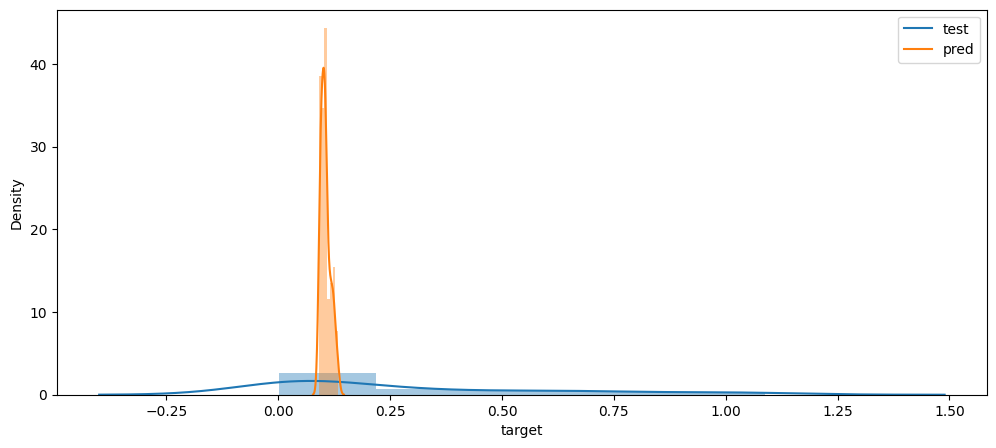

In [391]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

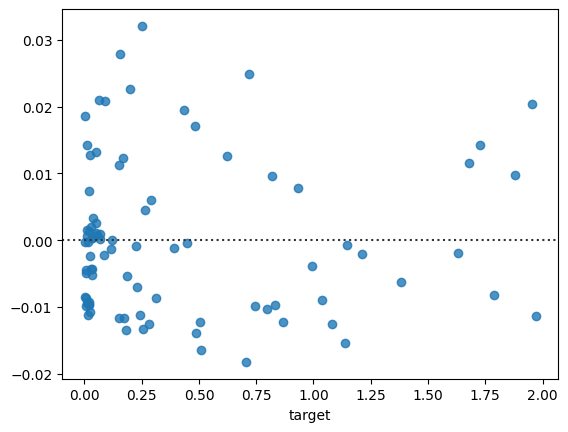

In [392]:
draw_residuals(y_test, y_pred, save_fig=False)

In [393]:
len(y_pred[y_pred <= 0])

0

## Tuning

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True)
train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,   
                        ) 
test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features,
                      )

In [80]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 100,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

In [ ]:
parameters_distr = {'depth': randint(5, 10),
                    'learning_rate': uniform(0.01, 0.1),
                    'iterations': [1000, 5000, 10000, 15000],
                    'l2_leaf_reg':  uniform(0.01, 0.5)
                     }

cat_model = cat.CatBoostRegressor(**cat_params)
grid = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_distr, 
                          cv=5, n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

cat_model = grid.best_estimator_
cat_model.save_model('views_3_finetuned_cat')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, emb

0:	learn: 0.0409679	total: 157ms	remaining: 2m 36s
1:	learn: 0.0402721	total: 187ms	remaining: 1m 33s
2:	learn: 0.0397917	total: 268ms	remaining: 1m 28s
3:	learn: 0.0392163	total: 354ms	remaining: 1m 28s
4:	learn: 0.0386634	total: 487ms	remaining: 1m 36s
5:	learn: 0.0382220	total: 550ms	remaining: 1m 31s
6:	learn: 0.0377707	total: 592ms	remaining: 1m 23s
7:	learn: 0.0374124	total: 674ms	remaining: 1m 23s
8:	learn: 0.0370133	total: 807ms	remaining: 1m 28s
9:	learn: 0.0367166	total: 993ms	remaining: 1m 38s
10:	learn: 0.0364223	total: 1.05s	remaining: 1m 34s
11:	learn: 0.0361288	total: 1.2s	remaining: 1m 38s
12:	learn: 0.0358993	total: 1.37s	remaining: 1m 44s
13:	learn: 0.0356448	total: 1.5s	remaining: 1m 45s
14:	learn: 0.0354023	total: 1.61s	remaining: 1m 45s
15:	learn: 0.0351398	total: 1.81s	remaining: 1m 51s
16:	learn: 0.0349367	total: 1.94s	remaining: 1m 52s
17:	learn: 0.0347334	total: 2.02s	remaining: 1m 50s
18:	learn: 0.0345633	total: 2.11s	remaining: 1m 48s
19:	learn: 0.0343588	tot

In [56]:
# best_cat = cat.CatBoostRegressor(**cat_params)      # parameters not required.
# best_cat.load_model('views_3_finetuned_cat')

In [82]:
y_pred = cat_model.predict(X_test)

MAE 0.03367143740403902
R2 0.19489317778678694
Adj R2 0.1921199528308316


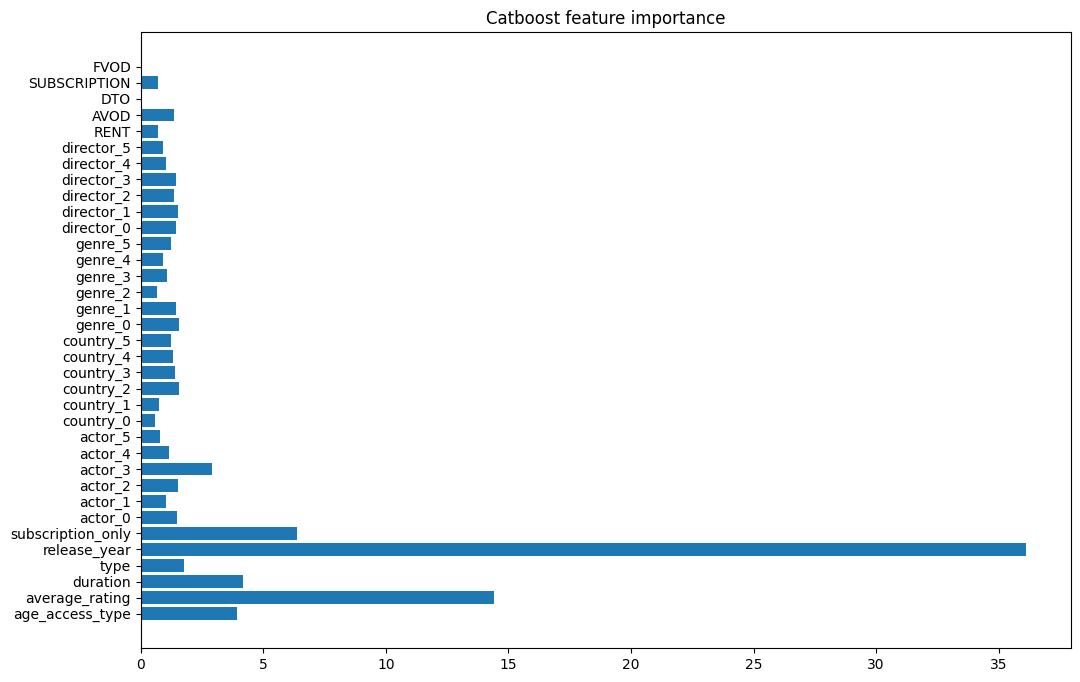

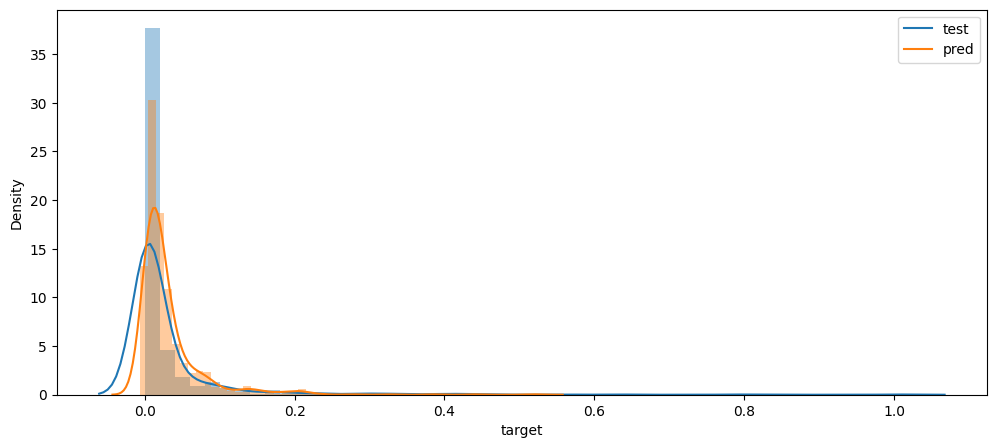

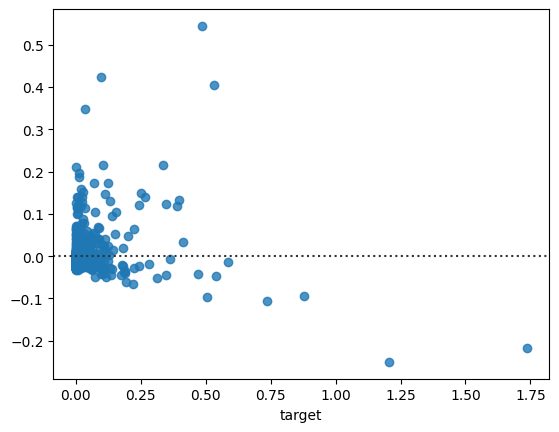

In [83]:
get_metrics(y_test, y_pred, X)
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')
draw_residuals(y_test, y_pred, save_fig=False)

In [48]:
len(y_pred[y_pred <= 0])

71

In [87]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   0.0045609797537924405
RMSE:  0.06753502612565157
R2:    0.2360049275931868
MAE:   0.029449491515247908
MedAE: 0.012390380156556524
------------------------------
